In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
%matplotlib inline

In [384]:
from itertools import islice, count

In [10]:
import scipy

In [11]:
import scipy.integrate

In [2]:
V, R = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(.5,6, 100))

In [3]:
H = 0
w = .95
m = 2

In [4]:
Z = m* V**2/2 + m*w**2/(2*R**2) - 1/R
scale = m*w**2/2-1

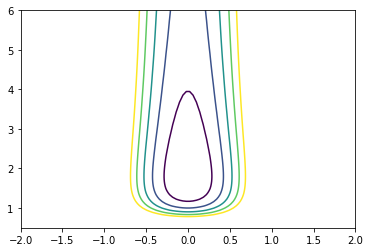

In [5]:
plt.contour(V, R, Z, levels= [3*scale, 2*scale, scale, 0, -scale, -2*scale])

In [6]:
np.linspace?

In [7]:
plt.contour?

In [9]:
np.vectorize?

In [10]:
def vec_to_mat(v):
    I = np.array([[0,0,0], [0,0,-1], [0,1,0]])
    J = np.array([[0,0,1], [0,0,0], [-1,0,0]])
    K = np.array([[0,-1,0], [1,0,0], [0,0,0]])
    return I*v[0] + J*v[1]+K*v[2]

In [14]:
I = np.array([[1,0,0], [0,2,0], [0,0,3]])

In [307]:
def inf_mom_update(I):
    I_inv = np.linalg.inv(I)
    def helper(w):
        w_dot = - I_inv.dot(np.cross(w, I.dot(w)))
        return w_dot
    return helper

In [13]:
def integrator(df, dt, x0):
    while True:
        x1 = x0+df(x0)*dt
        yield x1
        x0 = x1
    

In [116]:
n = 1000
ws = list(islice(integrator(inf_mom_update(I),0.01, [1,1,0]), n))

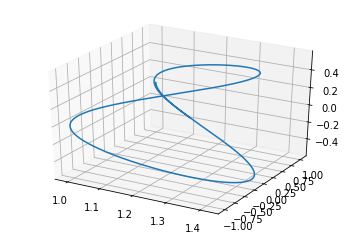

In [117]:
xs, ys, zs = list(zip(*map(tuple, ws)))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(xs, ys, zs)

In [152]:
def int_rot(dt, n, inf_rot):
    def matpow(w, m):
        if m == 0:
            return np.eye(w.shape[0])
        elif m == 1:
            return w
        else:
            half_m = m // 2
            return matpow(w, half_m).dot(matpow(w, m-half_m))
    def matpows(w):
        p = np.eye(w.shape[0])
        while True:
            yield p
            p = p.dot(w)
    def matexp(w, m):
        cumsum = 0
        fact = 1
        for p, k in zip(matpows(w), range(m+1)):
            fact *= k if k != 0 else 1
            cumsum += p/fact
        return cumsum
    # integrates infinitesimal rotations to actual rotation
    R = np.eye(3)
    for w in inf_rot:
        yield R
        R = R.dot(matexp(vec_to_mat(w)*dt, n))

In [153]:
list(int_rot(0.01, 5, ws))[1]

array([[ 9.99950000e-01,  8.33313889e-05,  9.99950000e-03],
       [ 1.66669444e-05,  9.99950000e-01, -9.99983333e-03],
       [-9.99983333e-03,  9.99950000e-03,  9.99900002e-01]])

In [154]:
r1s, r2s, r3s = zip(*[(R[:,0], R[:,1], R[:,2]) for R in int_rot(0.01, 10, ws)])

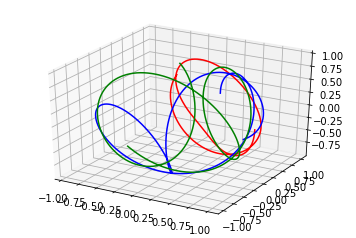

In [155]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(*zip(*map(tuple, r1s)), color="r")
ax.plot(*zip(*map(tuple, r2s)), color="b")
ax.plot(*zip(*map(tuple, r3s)), color="g")

In [157]:
def matexp(w, m):
    def matpows(w):
        p = np.eye(w.shape[0])
        while True:
            yield p
            p = p.dot(w)
    cumsum = 0
    fact = 1
    for p, k in zip(matpows(w), range(m+1)):
        fact *= k if k != 0 else 1
        print(fact)
        cumsum += p/fact
    return cumsum
e = matexp(vec_to_mat(ws[0]), 4)
np.linalg.qr(e, "complete")

1
1
2
6
24


(array([[-0.59587558, -0.4023706 ,  0.69500374],
        [-0.42335797, -0.57801512, -0.6976149 ],
        [ 0.68242239, -0.70992705,  0.1740783 ]]),
 array([[-9.78944577e-01, -4.25632395e-02,  1.41877465e-04],
        [ 0.00000000e+00, -9.78018842e-01,  1.35837271e-04],
        [ 0.00000000e+00,  0.00000000e+00,  9.57426685e-01]]))

In [158]:
e

array([[ 0.58332917,  0.41888842,  0.66527593],
       [ 0.41444399,  0.58332917, -0.6680537 ],
       [-0.6680537 ,  0.66527593,  0.16666759]])

In [159]:
vec_to_mat(ws[0])

array([[ 0.        ,  0.00333333,  1.        ],
       [-0.00333333,  0.        , -1.        ],
       [-1.        ,  1.        ,  0.        ]])

Solving by comparison with pendulum:

In [166]:
def is_diag(I):
    return np.isclose(I, np.diag(np.diagonal(I)))

def diag_from(I):
    if isinstance(I, np.array):
        assert is_diag(I), "I must be diagonal or a vector, not %s" % I
        I = np.diaganol(I)
    return I

def get_ks(I, Pi):
    I = diag_from(I)
    assert len(Pi.shape) == 1, "Pi must be a vector, not %s" % Pi
    k1 = 1/np.sqrt(1/I[0]-1/I[2])
    k2 = 1/np.sqrt(1/I[1]-1/I[2])
    k3 = 1/np.sqrt(I[2]*(I[1]-I[0])/(I[1]*(I[2]-I[0])))
    K = Pi[0]**2/(2*k1**2) + Pi[1]**2/(2*k2**2)
    return K, [k1,k2,k3], I

In [165]:
def get_thetas(theta, dtheta, I, Pi, dt):
    K, [k1,k2,k3], I = get_ks(I, Pi)
    w = -2*K/(k1*k2*I[2])
    while True:
        yield theta
        dtheta += w*np.sin(2*theta)*dt
        theta += dtheta*dt
        

array([[1, 0, 0],
       [0, 2, 0],
       [0, 0, 3]])

In [421]:
x = scipy.integrate.solve_ivp(
    lambda t, y: inf_mom_update(I)(y), 
    (0, 50), 
    [1,0.1,0],  
    dense_output=True,
    max_step=0.1
)


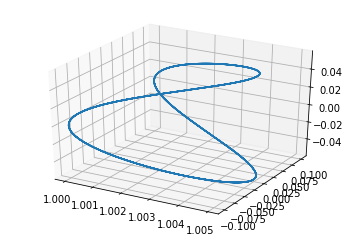

In [422]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(*x["y"])

In [423]:
def dr(w_sol):
    def helper(t, R):
        R = np.reshape(R, [3,3])
        return np.reshape(R.dot(vec_to_mat(w_sol(t))).dot(R),-1)
    return helper
    

In [427]:
RR = scipy.integrate.solve_ivp(
    dr(x["sol"]), 
    (0, 50), 
    np.reshape(np.eye(3), -1), 
    max_step=0.01
)

In [428]:
R_sol = [R.reshape([3,3]) for R in np.transpose(RR["y"])]
r1s, r2s, r3s = zip(*[(R[:,0], R[:,1], R[:,2]) for R in R_sol])

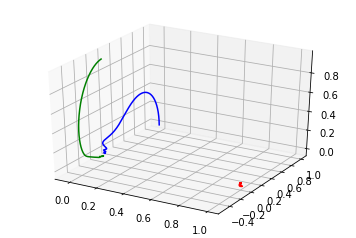

In [429]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(*zip(*map(tuple, r1s)), color="r")
ax.plot(*zip(*map(tuple, r2s)), color="b")
ax.plot(*zip(*map(tuple, r3s)), color="g")

Plot of $SO(3)$:

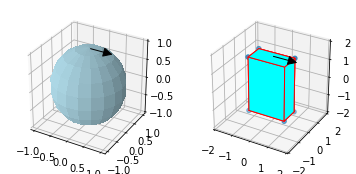

In [622]:
from itertools import product, combinations
from matplotlib.colors import LightSource

# n = [2,.5,.5]
# theta=None
theta, phi, tau = 0, 0, 0
rot = euler_rot(theta,phi,tau)

fig = plt.figure()
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.set_aspect("equal")

# create light source object.
ls = LightSource(azdeg=0, altdeg=65)
# shade data, creating an rgb array.
# rgb = ls.shade(z, plt.cm.RdYlBu)

# draw sphere
u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
x = np.cos(u)*np.sin(v)
y = np.sin(u)*np.sin(v)
z = np.cos(v)
ax.plot_surface(x, y, z, antialiased=False, color="lightblue")

# draw a point
# ax.scatter([0], [0], [0], color="g", s=100)

# draw a vector
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d


class Arrow3D(FancyArrowPatch):

    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0, 0), (0, 0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0], ys[0]), (xs[1], ys[1]))
        FancyArrowPatch.draw(self, renderer)
# base, vec = list(map(lambda p: quat_rot(quat_from_rot(n, theta), p), [[0,0,1],[0.75,0,1]]))
base, vec = list(map(rot, [[0,0,1],[0.75,0,1]]))
a = Arrow3D([base[0], vec[0]], [base[1], vec[1]], [base[2], vec[2]], mutation_scale=20,
            lw=1, arrowstyle="-|>", color="k")
ax.add_artist(a)

# Plot a box:
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.set_aspect("equal")
ax.set_xlim3d(-2,2)
ax.set_ylim3d(-2,2)
ax.set_zlim3d(-2,2)
Box3d(2,1,3,rot = rot).draw(ax)
base, vec = list(map(rot, [[0,0,1.6],[1.5,0,1.6]]))
a = Arrow3D([base[0], vec[0]], [base[1], vec[1]], [base[2], vec[2]], mutation_scale=20,
            lw=1, arrowstyle="-|>", color="k")
ax.add_artist(a)
plt.plot
plt.show()

In [141]:
def quat_mul(v, w):
    v0 = v[0]
    vr = np.array(v[1:])
    w0 = w[0]
    wr = np.array(w[1:])
    return np.concatenate([[v0*w0+np.dot(vr,wr)], v0*wr+w0*vr+np.cross(vr,wr)] )

def quat_conj(v):
    v0 = v[0]
    vr = np.array(v[1:])
    return np.concatenate([[v0], -vr] )

def quat_rot(v, q):
    v_norm = np.sqrt(np.dot(v,v))
    v = np.array(v)/v_norm
    w = np.concatenate([[0], q])
    return np.array(quat_mul(v, quat_mul(w, quat_conj(v)))[1:])

def quat_rot_stab(v, q):
    v_norm = np.sqrt(np.dot(v,v))
    v = np.array(v)/v_norm
    w = np.concatenate([[0], q])
    w_norm = np.sqrt(np.dot(w,w))
    result = np.array(quat_mul(v, quat_mul(w/w_norm, quat_conj(v)))[1:])
    result_norm = np.sqrt(np.dot(result, result))
    return result*w_norm/result_norm

In [386]:
def quat_from_rot(n, theta=None):
    n = np.array(n)
    norm = np.sqrt(n.dot(n))
    if np.isclose(norm, 0):
        return np.array([1,0,0,0])
    if theta is None:
        theta = norm
    return np.concatenate([[np.cos(theta/2)], np.sin(theta/2)*n])

In [5]:
quat_rot(quat_from_rot([1,0,0],np.pi/2), [0,1,0])

array([0.00000000e+00, 2.22044605e-16, 1.00000000e+00])

In [6]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection
import matplotlib.pyplot as plt

class Box3d():
    def __init__(self, dx, dy, dz, n=None, theta=None, rot=None):
        dx, dy, dz = dx/2, dy/2, dz/2
        if rot is None:
            rot = lambda p: quat_rot(quat_from_rot(n, theta), p)
        self.points = np.array(list(map(rot,
            [[-dx, -dy, -dz],
              [dx, -dy, -dz ],
              [dx, dy, -dz],
              [-dx, dy, -dz],
              [-dx, -dy, dz],
              [dx, -dy, dz ],
              [dx, dy, dz],
              [-dx, dy, dz]]
        )))
        

    def draw(self, renderer):
        Z = np.array(self.points)

        # plot vertices
        ax.scatter3D(Z[:, 0], Z[:, 1], Z[:, 2])

        # list of sides' polygons of figure
        verts = [[Z[0],Z[1],Z[2],Z[3]],
         [Z[4],Z[5],Z[6],Z[7]], 
         [Z[0],Z[1],Z[5],Z[4]], 
         [Z[2],Z[3],Z[7],Z[6]], 
         [Z[1],Z[2],Z[6],Z[5]],
         [Z[4],Z[7],Z[3],Z[0]], 
         [Z[2],Z[3],Z[7],Z[6]]]

        # plot sides
        renderer.add_collection3d(Poly3DCollection(verts, 
         facecolors="cyan", linewidths=1, edgecolors='r', alpha=.25))

<function matplotlib.pyplot.plot(*args, **kwargs)>

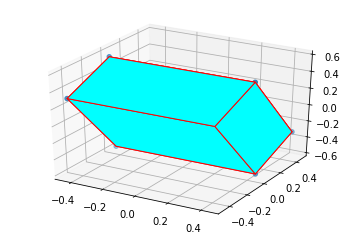

In [749]:
fig = plt.figure()
ax = fig.gca(projection='3d')
Box3d(1,.5,1,[1,0,0],0.5).draw(ax)
plt.plot

In [567]:
x = quat_from_rot([0,0,4])
print(x)
x.dot(x)

[0.54030231 0.         0.         0.84147098]


1.0

In [566]:
quat_rot()

1.0
[0.73168887 0.         0.         0.68163876]
[0 0 0 1]
1.0
[0.        0.        0.0707372]
0.07073720166770286


array([0., 0., 1.])

In [574]:
x = quat_from_rot([0,0,3.2])
quat_rot(x,[0,0,1])

1.0
[0.69670671 0.         0.         0.71735609]
[0 0 0 1]
1.0
[ 0.          0.         -0.02919952]
0.029199522301288694


array([ 0.,  0., -1.])

In [585]:
def euler_rot(theta, phi, tau):
    R_theta = np.array([
        [1,0,0],
        [0,np.cos(theta),-np.sin(theta)],
        [0,np.sin(theta), np.cos(theta)]
    ])
    R_phi = np.array([
        [np.cos(phi),0,np.sin(phi)],
        [0,1,0],
        [-np.sin(phi),0, np.cos(phi)]
    ])
    R_tau = np.array([
        [np.cos(tau),np.sin(tau),0],
        [-np.sin(tau),np.cos(tau),0],
        [0,0,1]
    ])
    def helper(v):
        return R_tau.dot(R_phi.dot(R_theta.dot(v)))
    return helper
    

In [230]:
def euler_eq(I):
    I_inv = np.linalg.inv(I)
    def helper(t, l_q):
        l = l_q[:3]
        q = l_q[3:]
        dl = np.cross(l, I_inv.dot(l))
        w_quat = np.concatenate([[0],I_inv.dot(l)])
        dq = quat_mul(q, w_quat/2)
        return np.concatenate([dl, dq])
    return helper

def reg_euler_eq(I, reg):
    I_inv = np.linalg.inv(I)
    def helper(t, l_q):
        l = l_q[:3]
        q = l_q[3:]
        dl = np.cross(l, I_inv.dot(l))
        w_quat = np.concatenate([[0],I_inv.dot(l)])
        q_norm = np.sqrt(q.dot(q))
        dq = quat_mul(q, w_quat/2)-reg*(1-q_norm)**2*q
        return np.concatenate([dl, dq])
    return helper

def euler_jac(I):
    I_inv = np.linalg.inv(I)
    def helper(t, l_q):
        l = l_q[:3]
        q = l_q[3:]
        dl_l = [
            2*np.cross([1,0,0], I_inv.dot(l)),
            2*np.cross([0,1,0], I_inv.dot(l)),
            2*np.cross([0,0,1], I_inv.dot(l))
        ]
        dq_l = [
            quat_mul(q, np.concatenate([[0],I_inv[:,0]])),
            quat_mul(q, np.concatenate([[0],I_inv[:,1]])),
            quat_mul(q, np.concatenate([[0],I_inv[:,2]]))
        ]
        w_quat = np.concatenate([[0],I_inv.dot(l)])
        dq_q = [
            quat_mul([1,0,0,0], w_quat),
            quat_mul([0,1,0,0], w_quat),
            quat_mul([0,0,1,0], w_quat),
            quat_mul([0,0,0,1], w_quat)
        ]
        dl_q_l = [np.concatenate([dl_li,dq_li]) for dl_li, dq_li in zip(dl_l, dq_l)]
        dl_q_q = [np.concatenate([[0,0,0],dq_qi]) for dq_qi in dq_q]
        return np.transpose(np.vstack(dl_q_l+dl_q_q))
    return helper
    
    

In [231]:
LQ = scipy.integrate.solve_ivp(
    euler_eq(I), 
    (0, 300), 
    [1,.1,0,1,0,0,0], 
    jac = euler_jac(I),
    method="LSODA"
)

In [286]:
def chained_solver(I, l, Dt):
    q = [1,0,0,0]
    l_q = np.concatenate([l, q])
    while True:
        LQ = scipy.integrate.solve_ivp(
            euler_eq(I), 
            (0, Dt), 
            l_q, 
            jac = euler_jac(I),
            method="LSODA"
        )
        yield from np.transpose(LQ["y"])
        l_q = normalize_q(LQ["y"][:,-1])
        

In [301]:
LQy = list(islice(chained_solver(I, [0,0,1], 1), 3000))

In [302]:
L_sol = [l_q[:3] for l_q in LQy]

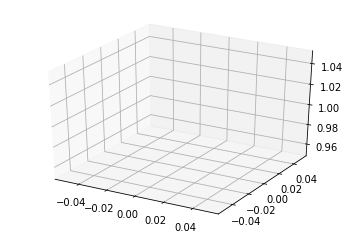

In [303]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(*zip(*map(tuple, L_sol)))

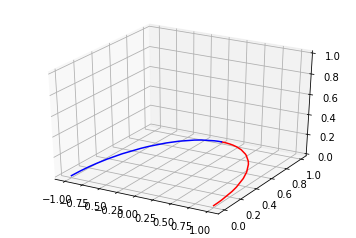

In [304]:
Q_sol = [l_q[3:] for l_q in LQy]
x_sol = [quat_rot_stab(q, [1,0,0]) for q in Q_sol]
y_sol = [quat_rot_stab(q, [0,1,0]) for q in Q_sol]
z_sol = [quat_rot_stab(q, [0,0,1]) for q in Q_sol]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(*zip(*map(tuple, x_sol)), color="r")
ax.plot(*zip(*map(tuple, y_sol)), color="b")
ax.plot(*zip(*map(tuple, z_sol)), color="g")

In [305]:
np.transpose(np.vstack([[1,2],[3,4]]))

array([[1, 3],
       [2, 4]])

In [22]:
from matplotlib.animation import FuncAnimation

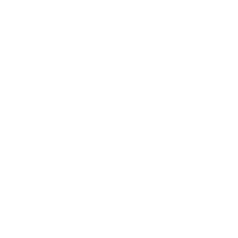

In [23]:
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
xdata, ydata = [], []
ln, = plt.plot([], [], 'ro', animated=True)

def init():
    ax.set_aspect("equal")
    ax.set_xlim3d(-2,2)
    ax.set_ylim3d(-2,2)
    ax.set_zlim3d(-2,2)
    Box3d(2,1,3, [1,1,1], theta=0).draw(ax)
    return ln,

def update(frame):
    q = Q_sol[frame]
    Box3d(2,1,3, rot=lambda p: quat_rot(q, p)).draw(ax)
    return ax,

ani = FuncAnimation(fig, update, frames=range(len(Q_sol)),
                    init_func=init, blit=True)
ani.save("out.mpg")

In [37]:
def reg_integrator(df, dt, reg, x, t=0):
    while True:
        x = reg(x+df(t,x)*dt)
        t += dt
        yield x

In [55]:
def normalize(v):
    v_norm = np.sqrt(np.dot(v,v))
    return np.array(v)/v_norm

def normalize_q(l_q):
    l = l_q[:3]
    q = l_q[3:]
    return np.concatenate([l, normalize(q)])

In [212]:
int_motion = reg_integrator(euler_eq(I), 0.01, normalize_q, [1,.1,0,1,0,0,0])

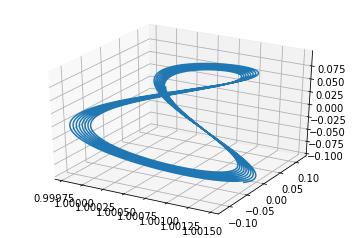

In [213]:
ws = list(islice(int_motion,9000))
xs, ys, zs, *_ = list(zip(*map(tuple, ws)))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(xs, ys, zs)

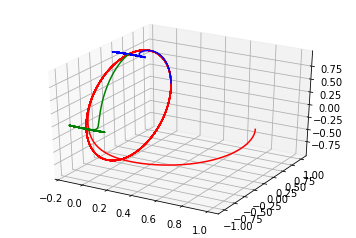

In [214]:
Q_sol = [l_q[3:] for l_q in ws]
x_sol = [quat_rot_stab(q, [1,0,0]) for q in Q_sol]
y_sol = [quat_rot_stab(q, [0,1,0]) for q in Q_sol]
z_sol = [quat_rot_stab(q, [0,0,1]) for q in Q_sol]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(*zip(*map(tuple, x_sol)), color="r")
ax.plot(*zip(*map(tuple, y_sol)), color="b")
ax.plot(*zip(*map(tuple, z_sol)), color="g")

In [215]:
50/0.01

5000.0

In [242]:
def poinsot(I, w, dt):
    q = [1,0,0,0]
    L = I.dot(w)
    L_n = normalize(L)
    H = np.dot(w, I.dot(w))
    difference = L_n.dot(w)*L_n
    def project_to_inv_plane(w):
        zero_projection = w-L_n.dot(w)*L_n
        return zero_projection + difference
    def find_new_w(I):
        def energy(w):
            w_proj = project_to_inv_plane(w)
            return np.dot(w_proj,I.dot(w_proj))
        x = scipy.optimize.minimize(energy,x0=w)["x"]
        return project_to_inv_plane(x)
    def find_new_I(q):
        I_vert = [I[:,0], I[:,1], I[:,2]]
        def qr_tr(I_j):
            return quat_rot(q, I_j.transpose()).reshape([3,1])
        I_vert_new = list(map(qr_tr, I_vert))
        return np.hstack(I_vert_new)
    def find_new_q(w, dt):
        quat_w = dt*np.concatenate([[0], w])/2
        new_q = quat_mul(quat_w, q)
#         w_norm = np.sqrt(w.dot(w))
        q_w = quat_from_rot(np.array(w)*dt)
        return normalize(quat_mul(q_w, q))
    while True:
        q = find_new_q(w, dt)
        yield q
        I = find_new_I(q)
        w = find_new_w(I)
        asse rt np.isclose(w.dot(I.dot(w)), H), "Energy changing"

In [245]:
list(islice(poinsot(I, [1,4,5],.01), 100))

AssertionError: Momentum changing: Expect [ 1  8 15], got [ 1.04886212  7.96876651 15.00387536]. Vals: {'w': array([0.95016987, 4.01208439, 4.996877  ]), 'I': array([[ 0.99947505, -0.04999125,  0.0599895 ],
       [ 0.02499563,  1.99895009, -0.01499738],
       [-0.0199965 ,  0.00999825,  2.99842514]]), 'q': array([0.99986875, 0.00249989, 0.00999956, 0.01249945])}

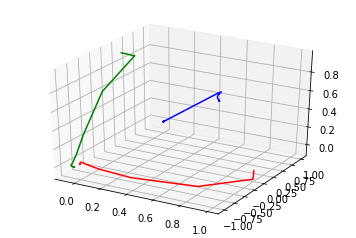

In [207]:
Q_sol = [l_q[0:] for l_q in islice(poinsot(I, [.1,1,0],.01), 100)]
x_sol = [quat_rot_stab(q, [1,0,0]) for q in Q_sol]
y_sol = [quat_rot_stab(q, [0,1,0]) for q in Q_sol]
z_sol = [quat_rot_stab(q, [0,0,1]) for q in Q_sol]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(*zip(*map(tuple, x_sol)), color="r")
ax.plot(*zip(*map(tuple, y_sol)), color="b")
ax.plot(*zip(*map(tuple, z_sol)), color="g")

In [395]:
sol = scipy.integrate.solve_ivp(
    lambda t, y: inf_mom_update(I)(y), 
    (0, 50), 
    [.1,1,0],
    max_step=0.5
)
tt=sol["t"]
w_t=sol["y"]

In [396]:
def orthonormalize(R):
    u, _, vh = np.linalg.svd(R)
    return u.dot(vh)

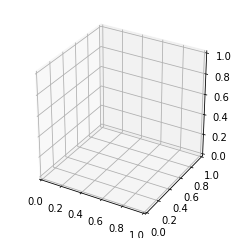

In [398]:
fig = plt.figure()
ax = fig.gca(projection='3d')
R = np.eye(3)
tp=0
for i, tn, w in zip(count(), tt, w_t.transpose()):
    ax.set_aspect("equal")
    ax.set_xlim3d(-2,2)
    ax.set_ylim3d(-2,2)
    ax.set_zlim3d(-2,2)
    
    dt = 3*(tn-tp)
    tp = tn
    q = quat_from_rot(dt*R.dot(w))
    R_ = np.hstack([quat_rot(q, R_i).reshape([3,1]) for R_i in R.transpose()])
    R = orthonormalize(R_)
    Box3d(1,.5,1,rot = lambda p: R.dot(p)).draw(ax)
    plt.savefig("imgs/fig_%04d.png" % i)
    ax.clear()

In [392]:
w_t.shape

(3, 34)

In [379]:
scipy.integrate.solve_ivp(
    lambda t, y: inf_mom_update(I)(y), 
    (0, 50), 
    [.1,1,0],
    max_step=0.1
)

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 3008
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.00000000e+00, 4.21956057e-02, 1.42195606e-01, 2.42195606e-01,
       3.42195606e-01, 4.42195606e-01, 5.42195606e-01, 6.42195606e-01,
       7.42195606e-01, 8.42195606e-01, 9.42195606e-01, 1.04219561e+00,
       1.14219561e+00, 1.24219561e+00, 1.34219561e+00, 1.44219561e+00,
       1.54219561e+00, 1.64219561e+00, 1.74219561e+00, 1.84219561e+00,
       1.94219561e+00, 2.04219561e+00, 2.14219561e+00, 2.24219561e+00,
       2.34219561e+00, 2.44219561e+00, 2.54219561e+00, 2.64219561e+00,
       2.74219561e+00, 2.84219561e+00, 2.94219561e+00, 3.04219561e+00,
       3.14219561e+00, 3.24219561e+00, 3.34219561e+00, 3.44219561e+00,
       3.54219561e+00, 3.64219561e+00, 3.74219561e+00, 3.84219561e+00,
       3.94219561e+00, 4.04219561e+00, 4.14219561e+00, 4.24219561e+00,
       4.34219561e+00, 4.44219561e+00, 